# DeepGenomeVector

Here, we introduce a framework for training a machine learning algorithm to learn the basic genetic principles underlying the gene composition of bacterial genomes. Given a set of desired pathways (e.g., glycolysis, TCA cycle, and butane degradation), our variational autoencoder (VAE) model strives to generate synthetic bacterial "genome vectors" - vectors denoting the full complement of genes that would need to be encoded to support a viable cell that supports the user-defined input functions.

This ipython notebook allows a user to:
- Load, pre-process, and filter data
- Perform data exploration on dataset & train-test splits
- Train or load a single VAE model
- Evaluate the output of the model
- Generate figures for the manuscript

To perform hyperparameter optimization, please use the hpo.py module. 

A few things to note about the data:
- Each genome has both a tla and tnum that can be used to identify it (tla = three letter abbreviation = genome ID, tnum = T number = genome ID)
- The terms "KO" (KEGG orthology number) and "gene" are used interchangeably

Note that to run this notebook you will need to update the configs.py file with paths to your data.

### Load libraries, format settings

In [1]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import random
import re
import sys
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import stats
import sklearn as sk
import torch

from genome_embeddings import config, corrupt, data, data_viz, \
                              evaluate, models, pathways, pre_process, \
                              trainable 

loaded train + test data


/opt/anaconda2/envs/deepgenome/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
# To run code, update config.py with the paths to intended data and output directories
OUT_DIR = config.DATA_ROOT+"output/"
DATA_DIR = config.DATA_ROOT+"data/"
replacement_threshold = 0.5 # probability over which binarizer converts to a 1  
plt.rcParams.update({'font.size': 14})

print("Data will be sourced from",DATA_DIR)
print("Files will be saved to",OUT_DIR)

Data will be sourced from /Users/natasha/Desktop/DeepGenome/data/
Files will be saved to /Users/natasha/Desktop/DeepGenome/output/


In [4]:
date = pre_process.datenow()
print("Today's date is",date)

Today's date is 2024-11-17-14-26-50


# Load dataset

In [5]:
tla_to_mod_to_kos, mod_sets, tla_to_tnum, \
tnum_to_tla, keepers, tnum_to_kos, n_kos_tot, all_kos, \
mod_to_ko_clean, all_kos,  \
train_data, test_data, train_genomes, test_genomes = pre_process.load_data(DATA_DIR)

# Data exploration

Start by exploring properties of the dataset. This will help determine how we want to apply filters, etc.

A single KEGG module can often be represented by multiple sets of genes (pre-filtering). Given that we are working with a dataset of limited size, we have represented each module by a single set of genes. That set is the most common one found in the full dataset. The histogram function below allows one to visualize the original diversity of gene sets per module. For example, for module M00001 (EMP glycolysis, glucose => pyruvate) there are 401 different variants of the module, each with a slightly different combination of genes. 

The most common variant of module M00001 occurs in 73 genomes. There are a total of 401 module variants.


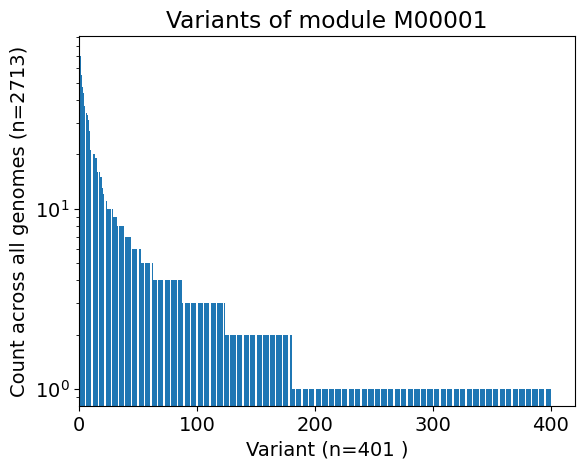

In [6]:
mod = 'M00001'
fig = data_viz.variants_of_mod(mod, mod_sets, tla_to_mod_to_kos)
plt.savefig(OUT_DIR+"module_variant_barplot_"+date+".pdf", bbox_inches='tight')

Plot histogram of KOs per genome in the full dataset (pre-filtering).

Median: 1835.0 Min: 0 Max: 4536


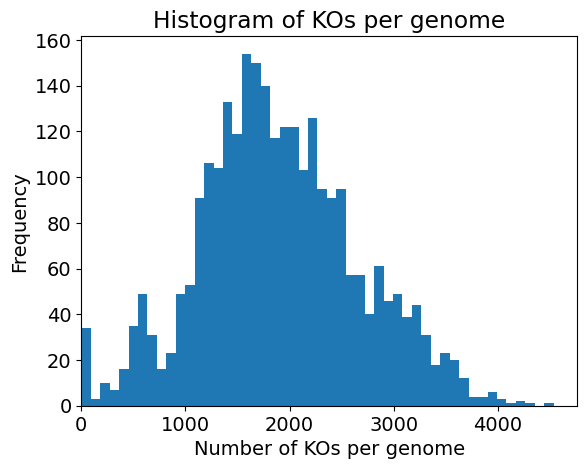

In [7]:
fig = data_viz.kos_per_genome(tnum_to_kos, train_genomes, test_genomes)
plt.savefig(OUT_DIR+"kos_per_genome_"+date+".pdf", bbox_inches='tight')

Plot the number of modules encoded by each genome

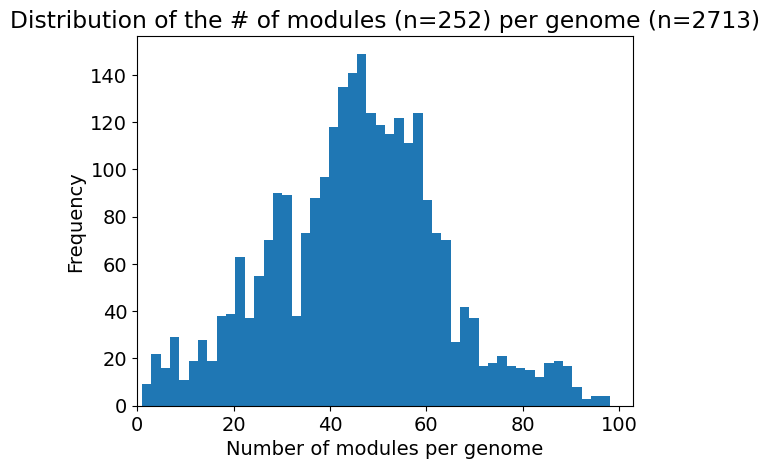

In [8]:
fig = data_viz.mods_by_genomes(tla_to_mod_to_kos)
plt.savefig(OUT_DIR+"mods_per_genome_"+date+".pdf", bbox_inches='tight')

Count and plot the number of genomes that encode each module (pre-filtering)

Number of mods encoded in only one genome: 23
Max number of genomes encoding a single mod 2672


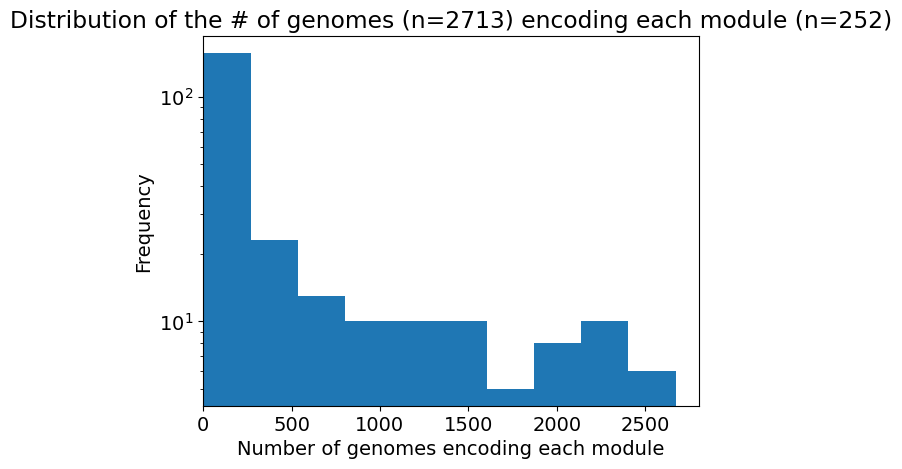

In [9]:
fig = data_viz.distrib_num_genomes_with_mod(tla_to_mod_to_kos)
plt.savefig(OUT_DIR+"genomes_per_mod"+date+".pdf", bbox_inches='tight')

Plot the percentage of genes per genome that contribute to modules, calculate some relevant stats

The total number of genes that occur in mods is 1359
The total number of genes in the dataset is 9874
Across the full dataset, the % of KOs that contribute to mods is 13.76%


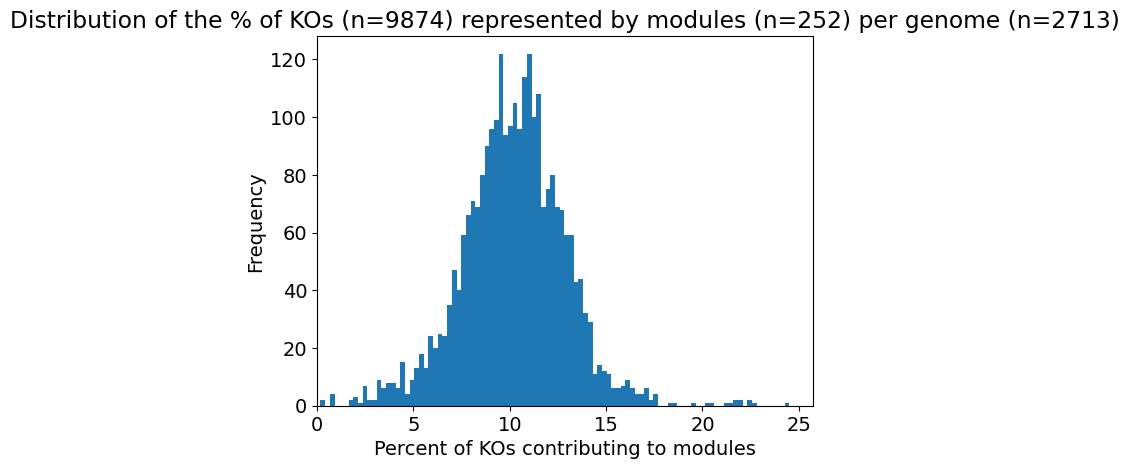

In [10]:
fig = data_viz.perc_genes_in_mods(tla_to_mod_to_kos, tnum_to_kos, tla_to_tnum, all_kos)
plt.savefig(OUT_DIR+"perc_genes_in_mods"+date+".pdf", bbox_inches='tight')

# Filter dataset

Remove any genomes with fewer than n_min KOs (e.g., this may represent endosymbionts or other bacteria with unusual lifestyles)

In [11]:
n_min = 500
train_data, test_data, train_genomes, test_genomes = pre_process.filter(n_min, train_data, test_data, 
                                                                        train_genomes, test_genomes)

Remove genomes that encode fewer than n_mods modules (anomalous)

In [12]:
n_mods = 10
train_data, train_genomes = pre_process.remove_low_nmods(train_data, train_genomes, \
                                                         tnum_to_tla, tla_to_mod_to_kos, n_mods)
test_data, test_genomes = pre_process.remove_low_nmods(test_data, test_genomes, \
                                                       tnum_to_tla, tla_to_mod_to_kos, n_mods)

Remove any columns that are all zeros in both the train and test sets (adjust train_data, test_data, and all_kos)

In [13]:
good_cols = ((train_data.sum(axis=0) != 0) | (test_data.sum(axis=0) != 0))
train_data = train_data[:,good_cols]
test_data = test_data[:,good_cols]
all_kos = np.array(all_kos)[good_cols].tolist()

Check how many rows and columns have all zeros for the training and test sets, respectively (# rows with all zeros, # columns with all zeros). 

Note that the number of all-zero rows should be zero for both. The number of all-zero columns will not be zero because in some cases, a gene may only one genome -- or a small number of genomes -- and occurs only in the training or test set.

In [14]:
# In just the training set, how many genomes and genes have zero entries 
(train_data.sum(axis=1) == 0).sum(), (train_data.sum(axis=0) == 0).sum()

(0, 77)

In [15]:
# In just the test set, how many genomes and genes have zero entries
(test_data.sum(axis=1) == 0).sum(), (test_data.sum(axis=0) == 0).sum()

(0, 1595)

Print some helpful stats

In [16]:
pre_process.helpful_data_stats(train_data, test_data)

The training set consists of 2305 genomes
The test set consists of 279 genomes
In total there are 2584 genomes
In total there are 9863 genes


# Corrupt input genomes
Due to the limited dataset size, we are going to perform corruptions on each genome and use those corrupted versions as input the the VAE. The model will be evaluated on how well it reconstructs the original, uncorrupted genome vector.

Note: creating new corruptions may take a while

In [17]:
# Set parameters
new_corrupt = False # do we want to create new corruptions or load from file
n_corrupt = 100 # number of corruptions to make per original genome vector
n_mods = 10 # max number of modules (mods) to keep during corruption
date_to_save = "2021-01-05_"+str(n_mods)+"mods" # if new_corrupt = True, will save corruptions as this
date_to_load = "2021-01-05_10mods" # if new_corrupt = False will load these

if new_corrupt:
    corrupted_train, c_train_genomes, train_input_mods, \
    corrupted_test, c_test_genomes, test_input_mods = corrupt.new_corrupt(OUT_DIR, train_data, train_genomes,
                                                            n_corrupt, tnum_to_tla, tla_to_mod_to_kos,
                                                            all_kos, mod_to_ko_clean, n_mods)
else:
    corrupted_train, c_train_genomes, train_input_mods, \
    corrupted_test, c_test_genomes, test_input_mods = corrupt.load_corrupt(OUT_DIR, date_to_load)    

Loading corrupted genome vectors from 2021-01-05_10mods


Confirm that there are no all-zero rows

In [18]:
non_zero_idx = corrupted_train.sum(axis=1) > n_min
print("training:",len(non_zero_idx), corrupted_train.shape[0])

non_zero_idx = corrupted_test.sum(axis=1) > n_min
print("test:",len(non_zero_idx), corrupted_test.shape[0])

training: 230500 230500
test: 27900 27900


What are the shapes of the training and test tensors?

In [19]:
corrupted_train.shape, corrupted_test.shape

(torch.Size([230500, 19726]), torch.Size([27900, 19726]))

Create a mapping from tla to taxonomic ID

In [20]:
train_tax_dict, test_tax_dict = pre_process.tax_dicts(c_train_genomes, train_input_mods,
                                                      c_test_genomes, test_input_mods)

# Visualization of final datasets

How does the distribution of genomes per phylum correlate between the training and test sets?

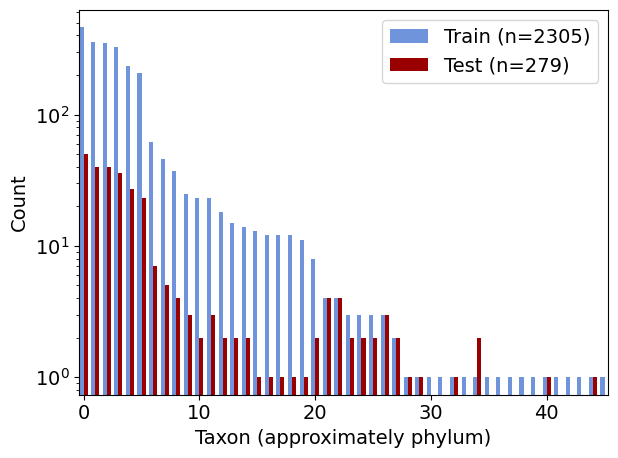

In [21]:
fig = data_viz.plot_tax_dist(c_train_genomes, c_test_genomes, train_tax_dict, test_tax_dict)
plt.savefig(OUT_DIR+"tax_dist_"+date+".pdf", bbox_inches='tight')

Plot the distribution of genes per genome vector. The number of genes annotated by KEGG per genome in the training and test sets are shown. Genomes with fewer than 500 gene annotations have been excluded from the dataset.

Min # genes: 528
Median # genes: 1885.0
Max # genes: 4536


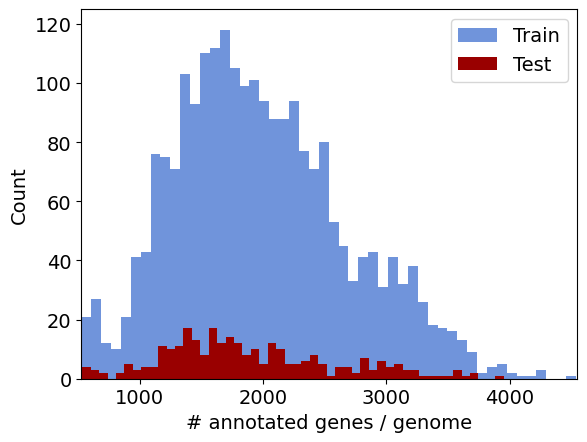

In [22]:
fig = data_viz.genes_per_genome(c_train_genomes, c_test_genomes, tnum_to_kos, tla_to_tnum)
plt.savefig(OUT_DIR+"genes_per_genome_"+date+".pdf", bbox_inches='tight')

Plot histogram showing the number of modules per training genome

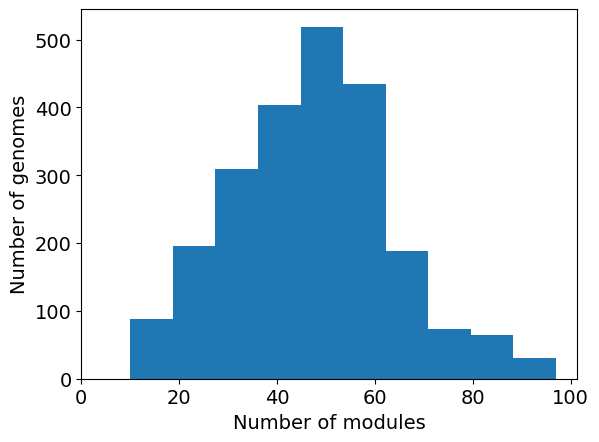

In [23]:
fig = data_viz.mods_per_train_genome(tla_to_mod_to_kos, c_train_genomes)
plt.savefig(OUT_DIR+"mods_per_train_genome_"+date+".pdf", bbox_inches='tight')

## Define and train a model

This notebook allows you to either train a single VAE model (no HPO) or load a model from file. To perform HPO use the standalone "hpo.py" script (recommended that you use an HPC cluster).

Note that the trainable.py script (both for training single VAEs here or using hpo.py) loads data from files saved to disk. This is because the files are huge and we want to do this only once. Therefore you must make sure you are using the desired files for training. To do this, edit the config file TRAIN_DATA_PATH and TEST_DATA_PATH parameters.

To train a model from scratch:

In [24]:
train_from_scratch = False
save_as = OUT_DIR+"VAE_"+date
n_mods = '10' # max number of modules used for corruption -- used to save label saved model, etc.
batch_size = 128

if train_from_scratch:
    # Set hyperparameters
    nn_layers = 3
    weight_decay = 0.1
    lr = 0.001
    kfolds = 10
    num_epochs = 3
    replacement_threshold = 0.5
    
    # Train model
    kld, bce, train_losses, test_losses,\
    train_f1s, test_f1s, model = trainable.train_single_vae(nn_layers, weight_decay, lr, \
                                                            batch_size, kfolds, num_epochs,\
                                                            replacement_threshold, OUT_DIR)
    
    # Save model and associated data
    print("Saving model with basename",save_as+"_"+n_mods+"mods")
    trainable.save_model(save_as+"_"+n_mods+"mods", kld, bce, train_losses, test_losses,\
                         train_f1s, test_f1s, model)

To load a model:

In [25]:
load_model = True
name = OUT_DIR+"VAE_2023-1-5-19-28-20_10mod"

if load_model:
    model, train_losses, test_losses,\
    train_f1s, test_f1s = trainable.load_model(name)

# Evaluate model performance

### Generate or load predictions on test set

In [26]:
# Remember model was trained using file specified in config / data
num_features = data.num_features
corrupted_test = data.test_data[:,:num_features]
uncorrupted_test = data.test_data[:,num_features:] 
tnum_to_tax = pre_process.make_tnum_to_tax(train_tax_dict, test_tax_dict, tla_to_tnum)

Make or load new predictions. Note that pred is predictions as probability values, whereas binary_pred is binary predictions. If you are not making new predictions, code assumes that you have loaded a previously trained model and will load the corresponding predictions.

In [27]:
new_preds = True # make new predictions (True) or load ones from file (False)
binarizer_threshold = 0.5
name = "redo-learning-curves"
pred, binary_pred = evaluate.make_pred(new_preds, model, corrupted_test, binarizer_threshold, name)

### Calculate test set F1 score (micro-average) and calculate TNs, FPs, FNs, TPs

In [28]:
f1 = sk.metrics.f1_score(uncorrupted_test, binary_pred, zero_division=0, average='micro')
print("Test set F1 score:",f1)

Test set F1 score: 0.8184155556710034


median F1 score: 0.827939952255444
min F1 score 0.3888299752562743
max F1 score 0.9894606323620583


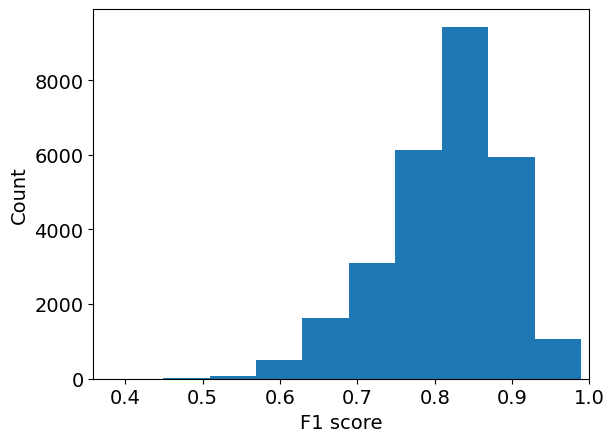

In [29]:
f1s, fig = evaluate.test_f1s(uncorrupted_test, binary_pred)
plt.savefig(OUT_DIR+"f1_dist_"+date+".pdf", bbox_inches='tight')

In [30]:
tns, fps, fns, tps = evaluate.confusion(uncorrupted_test, binary_pred)

The percentage of TNs, FPs, FNs, and TPs, respectively, is: 82.92 (%) 2.34 (%) 2.91 (%) 11.83 (%)


### Plot learning & ROC curves

Make a figure for the manuscript that includes optimization & performance LCs, the ROC curve, and the distribution of F1 scores. Loss and F1 scores were calculated per batch on the training and CV sets.

max F1 score 0.8215365247104706
median F1 score: 0.827939952255444
min F1 score 0.3888299752562743
max F1 score 0.9894606323620583


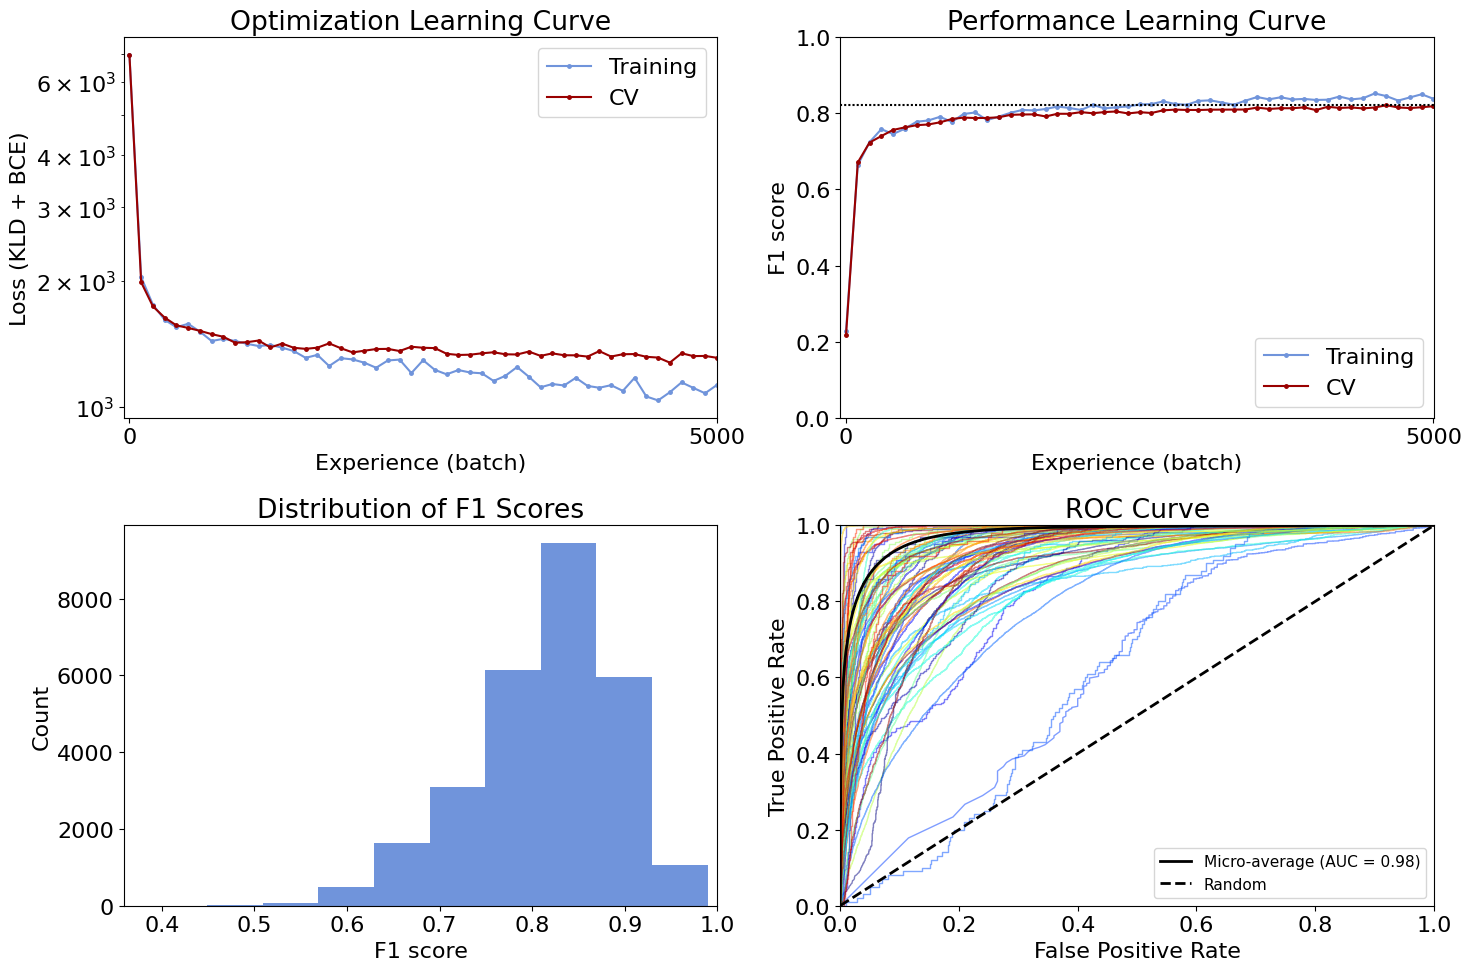

In [31]:
fig = evaluate.quantEval(train_losses, test_losses, train_f1s,
                                 test_f1s, uncorrupted_test.numpy(), pred.numpy(), 
                                 batch_size, uncorrupted_test, binary_pred)
fig.savefig(OUT_DIR+"quantEval_"+date+".pdf", dpi=200, bbox_inches='tight')

### Are the input genes present in the output?

There are 6739 instance of inputs being 100% present in output
This is out of 27900 instances or 24.15% of cases
There are 23802 instance of inputs being >=90% present in output (85.31%)


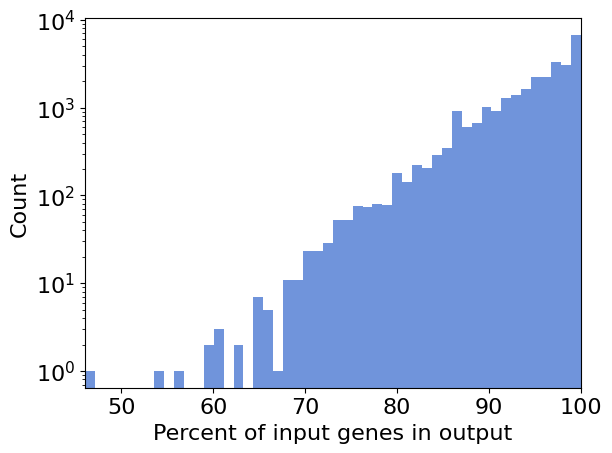

In [32]:
fig = evaluate.compare_in_n_out(binary_pred, corrupted_test)
fig.savefig(OUT_DIR+"compare_in_n_out"+date+".pdf", dpi=200, bbox_inches='tight')

### Is there a correlation between F1 score and the "common-ness" of the modules input to the VAE

How we will measure "common-ness": the number of training set genomes that encode that modules

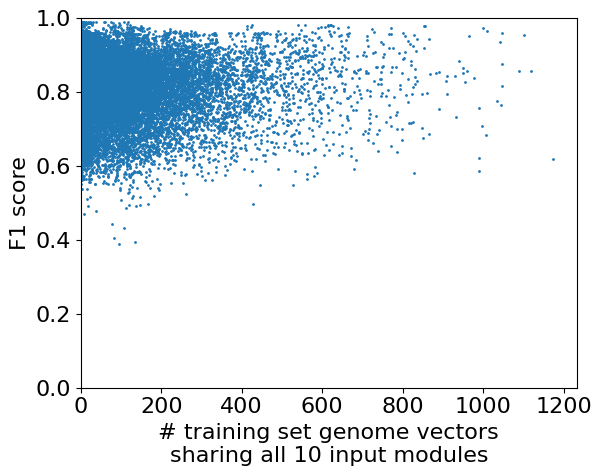

In [33]:
fig, num_shared_mods = evaluate.nmods_vs_f1(c_test_genomes, test_input_mods, tla_to_mod_to_kos, \
                                            tla_to_tnum, train_genomes, f1s)
plt.savefig(OUT_DIR+'numMods_vs_F1_"+date+".pdf', dpi=200)

### Is there are relationship between test F1 score and genetic relatedness (genus level) to training set genomes?

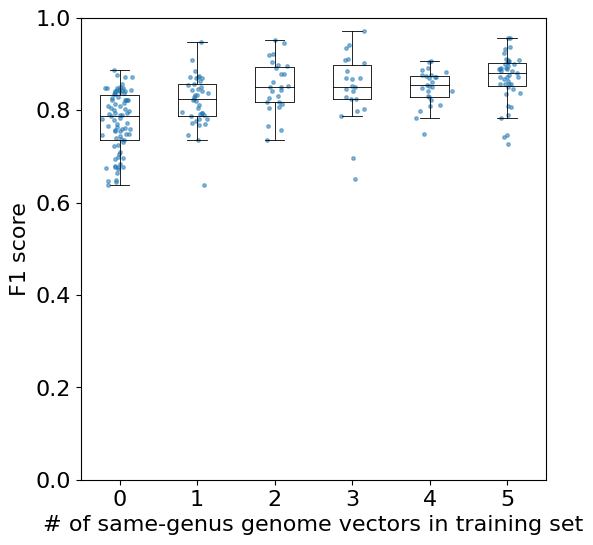

In [34]:
fig, groups = evaluate.genus_boxplot(c_test_genomes, tla_to_tnum, train_genomes,
                                     tnum_to_tax, f1s)
fig.savefig(OUT_DIR+"genus_boxplot_"+date+".pdf", bbox_inches='tight', dpi=200)

Is there a statistically significant difference?

In [35]:
anova, tukey = evaluate.genus_boxplot_stats(groups)

In [36]:
anova

,Source,ddof1,ddof2,F,p-unc,np2
0,group,5,232,18.941218,8.735648e-16,0.289882


In [37]:
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0442 0.0019  0.0114  0.077   True
   0.0    2.0   0.0762  0.001  0.0382 0.1141   True
   0.0    3.0   0.0721  0.001  0.0316 0.1125   True
   0.0    4.0   0.0734  0.001  0.0354 0.1113   True
   0.0    5.0   0.0929  0.001  0.0611 0.1246   True
   1.0    2.0    0.032 0.2633 -0.0107 0.0747  False
   1.0    3.0   0.0279 0.4795 -0.0171 0.0728  False
   1.0    4.0   0.0292 0.3659 -0.0135 0.0719  False
   1.0    5.0   0.0487  0.003  0.0114  0.086   True
   2.0    3.0  -0.0041    0.9 -0.0529 0.0447  False
   2.0    4.0  -0.0028    0.9 -0.0496  0.044  False
   2.0    5.0   0.0167 0.8465 -0.0252 0.0586  False
   3.0    4.0   0.0013    0.9 -0.0475 0.0501  False
   3.0    5.0   0.0208 0.7275 -0.0234  0.065  False
   4.0    5.0   0.0195 0.7364 -0.0224 0.0614  False
---------------------------------------------------


### How does the model perform on inputs originating from different phyla

Count the number of phylum members for all phyla in the training and test sets

In [38]:
train_phyla, test_phyla = evaluate.f1s_per_phylum(train_tax_dict, test_tax_dict, c_test_genomes, f1s)
print("FYI there are a total of", len(set(list(train_phyla.keys()) 
      + list(test_phyla.keys()))), "phyla in the full dataset") 

FYI there are a total of 46 phyla in the full dataset


Best: Chlorobi 0.910159529806885
Worst: Acidobacteria 0.6380254805586758


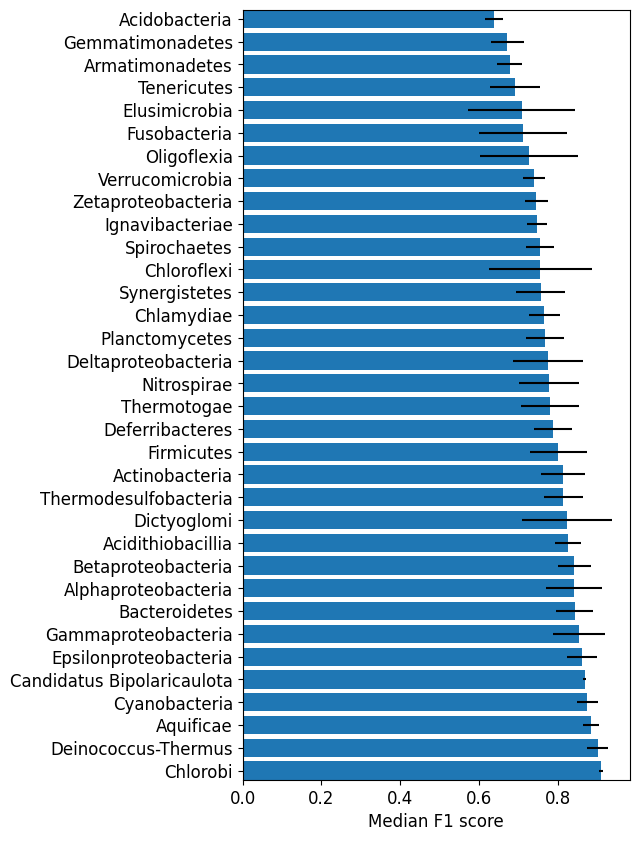

In [39]:
# Bars represent median absolute deviation
fig = evaluate.plot_f1_per_phylum(test_phyla, (5,10))
fig.savefig(OUT_DIR+"f1_per_phylum_"+date+".png", dpi=200, bbox_inches='tight')

In [40]:
# Are the results between phyla statistically significant?
stats.kruskal(*test_phyla.values())

KruskalResult(statistic=5423.214095986452, pvalue=0.0)

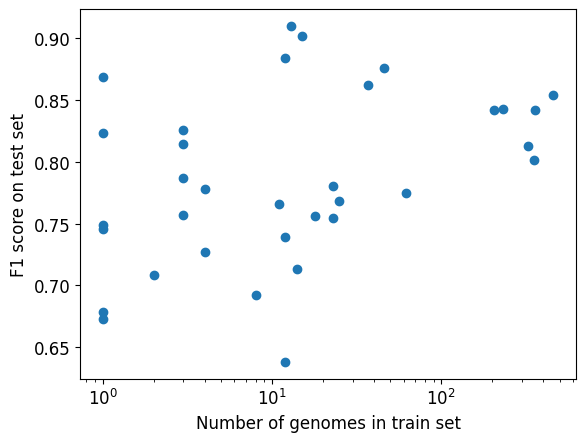

In [41]:
fig = evaluate.plot_count_vs_f1s(train_phyla, test_phyla)
fig.savefig(OUT_DIR+"count_vs_f1s_"+date+".png", dpi=200, bbox_inches='tight')

There appears to be an effect of number of training genomes / phylum on test set per phylum F1 score 

### How many times is each mod used in the various corrupted inputs?
Calculate the number of times each mod occurs in the training set corrupted genomes and plot.

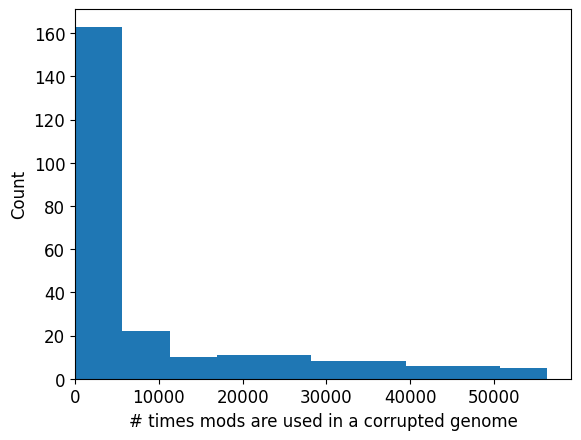

In [42]:
fig, train_out = evaluate.plot_train_count_hist(train_input_mods)
fig.savefig(OUT_DIR+"train_count_hist_"+date+".png", dpi=200, bbox_inches='tight')

### How does genome size correlate with F1 score

R2 0.033306056510898366
pvalue for test where null = slope is zero 1.6355577230559422e-207


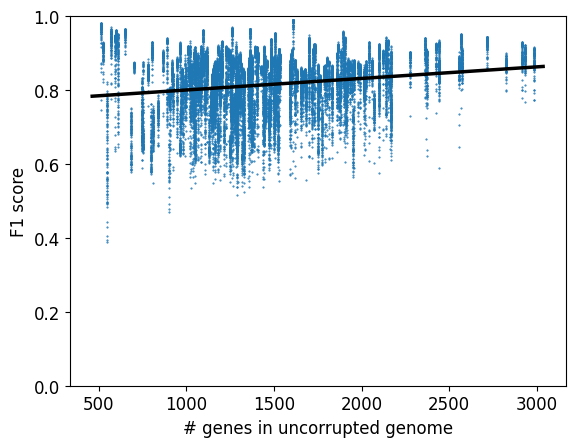

In [43]:
fig = evaluate.ngenesUncorrupted_vs_f1(uncorrupted_test, f1s)
fig.savefig(OUT_DIR+"ngenesUncorrupted_vs_f1_"+date+".png", dpi=200, bbox_inches='tight')

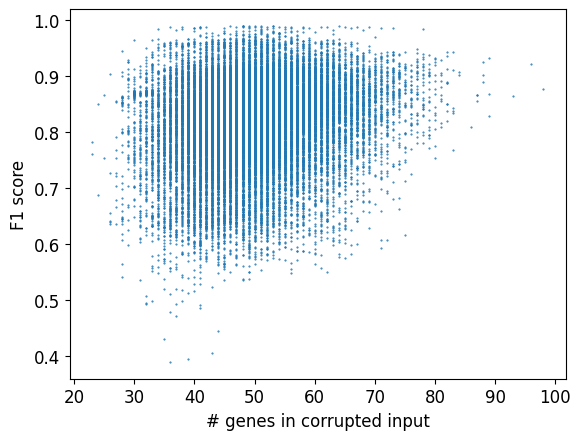

In [44]:
fig = evaluate.ngenesCorrupted_vs_f1(corrupted_test, f1s)
fig.savefig(OUT_DIR+"ngenesCorrupted_vs_f1_"+date+".png", dpi=200, bbox_inches='tight')

### Analyze F1 scores of actual KOs

To start, lets make a histogram for F1 score per gene 

There are 2209 KOs with F1=0 out of 9863 KOs. That is 22.39683666227314 %
There are 77 genes that are always off in the training set


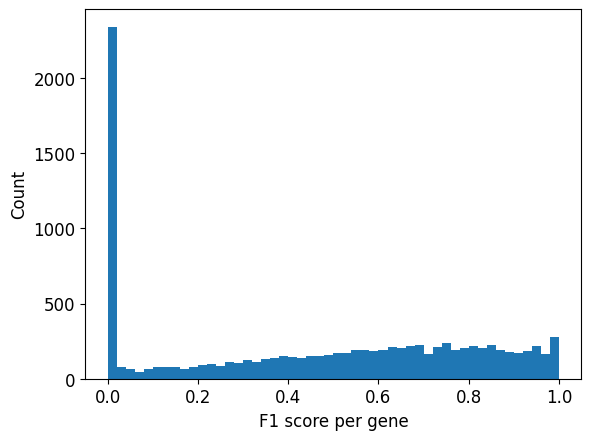

In [45]:
fig, ko_f1s = evaluate.f1_per_ko(uncorrupted_test, binary_pred, train_data)
fig.savefig(OUT_DIR+"f1_per_ko_"+date+".png", dpi=200, bbox_inches='tight')

Now plot gene count in the uncorrupted training set vs per gene test F1 score

max KO count: 230300
total number of training genomes: 230500
R2 0.42548006350349915
pvalue for test where null = slope is zero 0.0


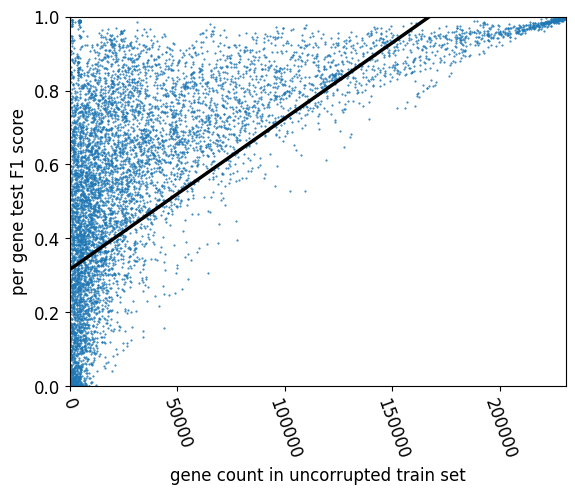

In [46]:
fig = evaluate.geneCount_vs_geneF1(corrupted_train, num_features, ko_f1s)
fig.savefig(OUT_DIR+"geneCount_vs_geneF1_"+date+".png", dpi=200, bbox_inches='tight')

### Generate multi-panel figure for paper

max KO count: 230300
total number of training genomes: 230500
R2 0.42548006350349915
pvalue for test where null = slope is zero 0.0
R2 0.033306056510898366
pvalue for test where null = slope is zero 1.6355577230559422e-207


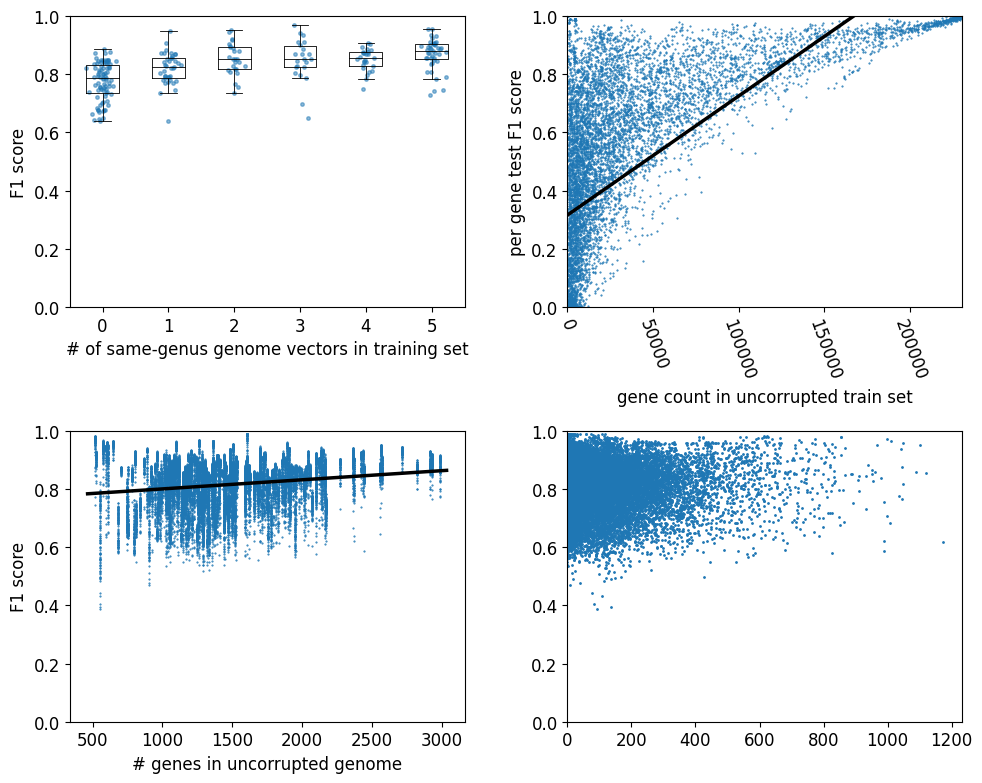

In [47]:
fig = evaluate.model_performance_factors(c_test_genomes, tla_to_tnum, tnum_to_tax, f1s,
                                         corrupted_train, num_features, ko_f1s, uncorrupted_test, 
                                         train_genomes, test_input_mods, tla_to_mod_to_kos)
fig.savefig(OUT_DIR+"bio_insights_contd_"+date+".png", dpi=400, bbox_inches='tight')

### F1 score on KOs + what metab pathway they are part of

Figure out which mods belong to which processes (e.g.: nucleotide metabolism) and subprocesses (e.g.: purine synthesis)

In [48]:
process_to_mod, mod_to_proc = evaluate.map_proc_mod()
subprocess_to_mod, mod_to_subproc = evaluate.map_subproc_mod()

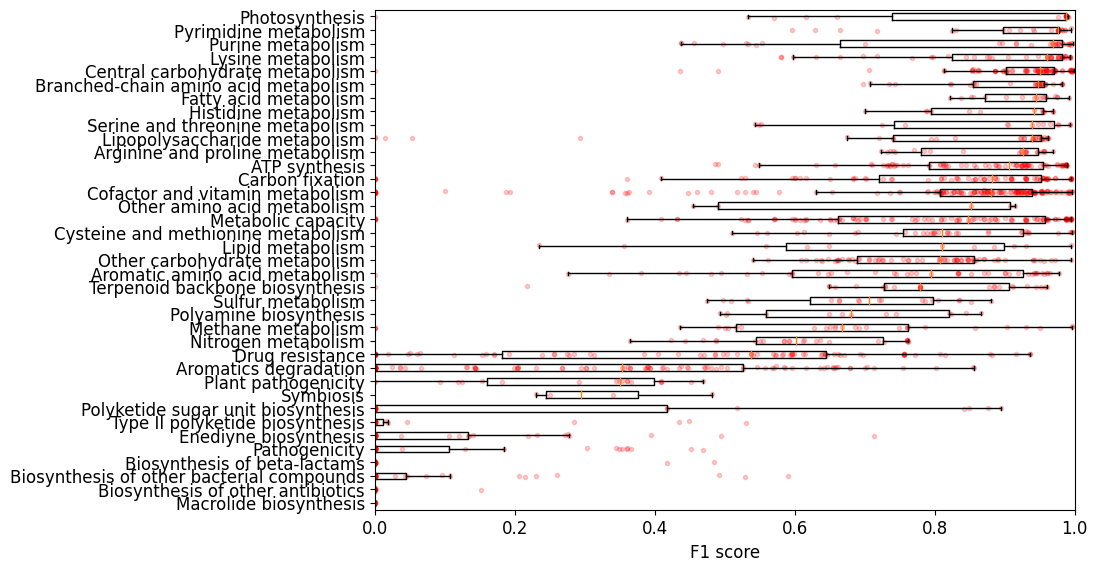

In [49]:
fig, proc_to_ko_F1s = evaluate.plot_metab_pathway_f1_horizontal(subprocess_to_mod, mod_to_ko_clean, \
                                                                all_kos, ko_f1s, (7,5))
fig.savefig(OUT_DIR+"metab_pathway_f1_horizontal_"+date+".png", dpi=200, bbox_inches='tight')

Is there a statistical difference between the F1 scores of genes from different processes?

In [50]:
stats.kruskal(*proc_to_ko_F1s.values())

KruskalResult(statistic=846.9725584851067, pvalue=1.6039657674151834e-154)

In [51]:
stats.kruskal(*proc_to_ko_F1s.values())

KruskalResult(statistic=846.9725584851067, pvalue=1.6039657674151834e-154)

### Generate a multi-panel figure for the paper

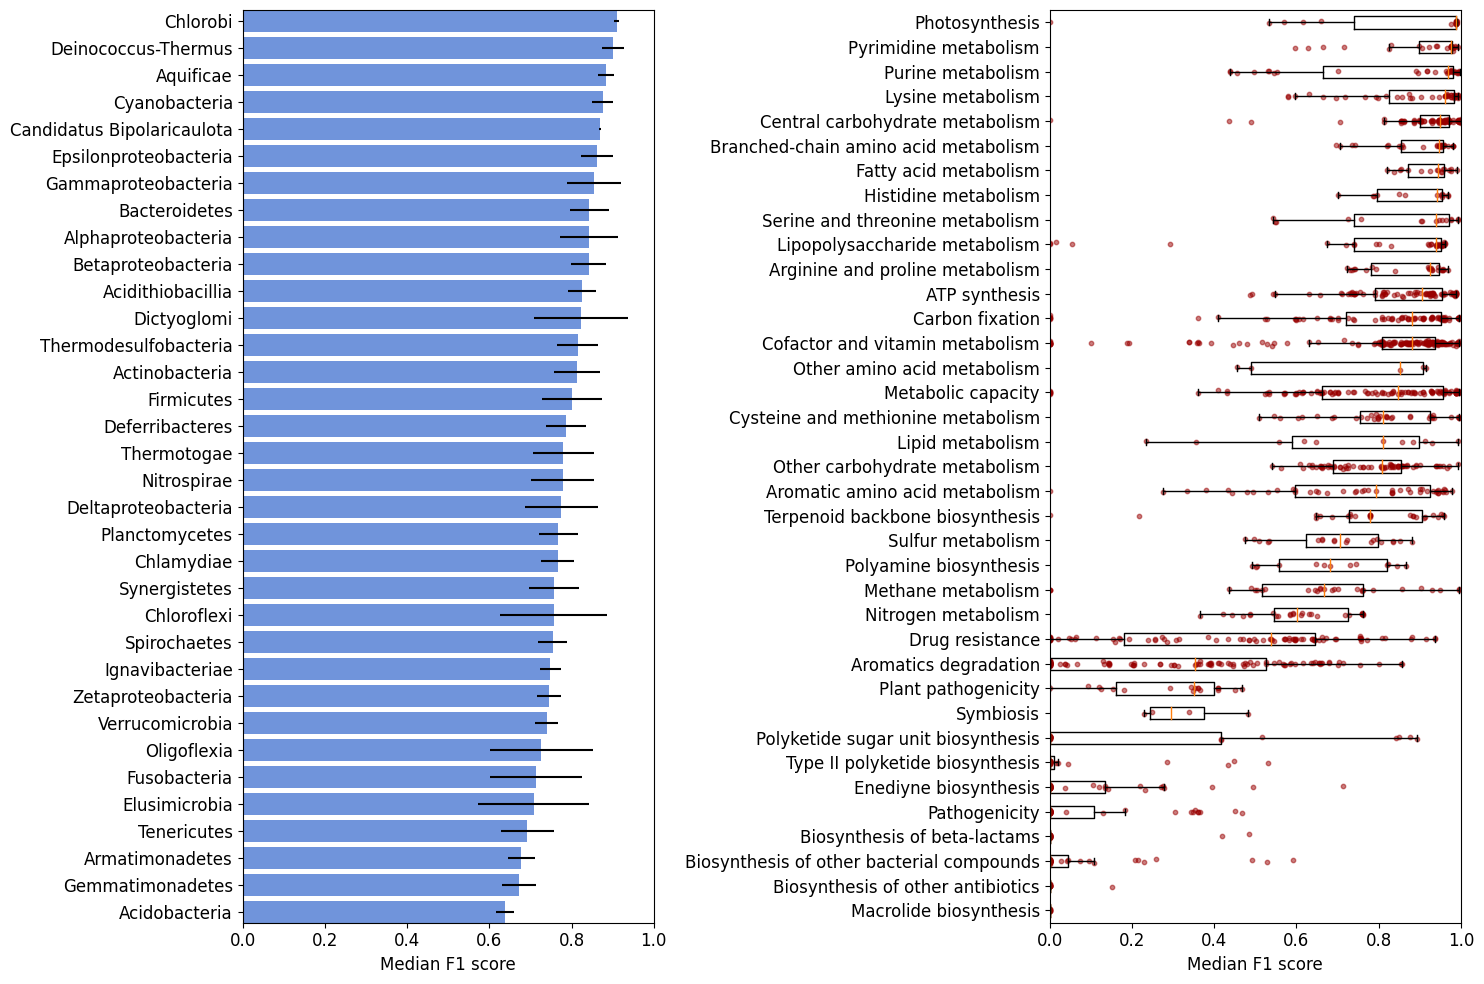

In [52]:
fig = evaluate.bio_insights_fig(test_phyla, subprocess_to_mod, all_kos, ko_f1s, mod_to_ko_clean)
fig.savefig(OUT_DIR+"bio_insights_fig_"+date+".pdf", dpi=200, bbox_inches='tight')

### How does the count of each mod in training set (pre-corruption) correlate with median F1 score

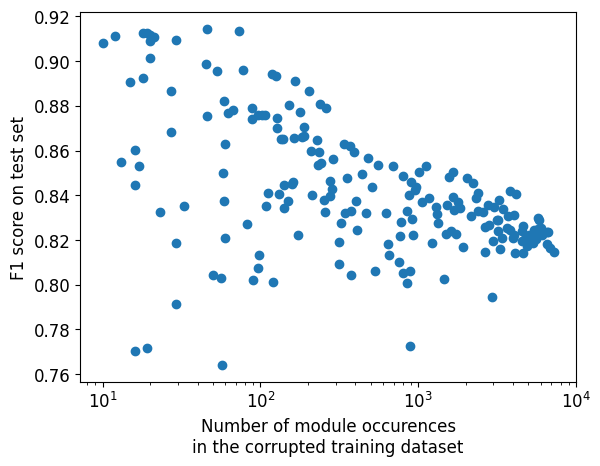

In [53]:
fig = evaluate.plot_mod_count_vs_f1(test_input_mods, f1s)
fig.savefig(OUT_DIR+"mod_count_vs_f1_"+date+".pdf", dpi=200, bbox_inches='tight')

# Qualitatively evaluate generated genome vectors

Now we have some idea about how well the model qualitatively performs. This is a fairly limited way of analyzing how "realistic" generated genome vectors are, though. For example, if we selected a set of 10 input modules for the VAE which are very common across bacteria, the VAE loss will be based on how will it reconstructed the original genome. But maybe there are 100 other genomes that encode the exact same 10 modules -- and therefore many different viable genomes that could encode that set.

So now let's look at some qualitative metrics for evaluating the realism of generated genome vectors.

First we will use the trained model to generate some new genome vectors

In [54]:
# Generate 100 genomes using random sets of 10 modules
new_genomes = False
date_to_load = "2023-1-5-19-28-20"

n_gen = 100 # number of genomes to generate
n_mods = 10 # number of mods to use as input

if new_genomes:
    print('files will be saved as',OUT_DIR+"generated_genomes_"+date+".pt and generated_genome_inputs_"+date+".pt")
    generated, generated_inputs = evaluate.generate_genomes(n_gen, all_kos, mod_to_ko_clean, n_mods, model)
    torch.save(generated, OUT_DIR+"generated_genomes_"+date+".pt")
    torch.save(generated_inputs, OUT_DIR+"generated_genome_inputs_"+date+".pt")
else:
    generated = torch.load(OUT_DIR+"generated_genomes_"+date_to_load+".pt")
    generated_inputs = torch.load(OUT_DIR+"generated_genome_inputs_"+date_to_load+".pt")

We will randomly select one of the generated genomes for in depth metabolic analysis later on

In [55]:
#idx = random.randint(test_data.shape[0], test_data.shape[0]+n_gen) 
idx=292 # For the paper, index 292 was randomly selected above. We will proceed with this index.
gen_idx = idx - test_data.shape[0] # generated genomes follow test set genomes in tensor

### Distribution of Hamming distances between test set vs generated genome vectors and training set genome vectors 

Motivation: we want to know if the model is recreating those in the training set (bad) vs generating novel genome vectors. To do this, we will measure how different generated genome vectors are from those in the training set. If we see that generated genome vectors have very low Hamming distance to training set genomes, that would suggest the model is just recreating training set genomes (unsatisfactory). For context, we perform the same calculation for real genome vectors from the test set vs the training set.

In [56]:
minh_test, minh_gen = evaluate.estimate_hamming_novelty(test_data, generated, train_data)

test set: median, MAD, min, and max 0.035993105545979925 0.02164599006387509 0.0018250025347257427 0.0964209672513434
generated: median, MAD, min, and max 0.0687924566561898 0.021420511000709727 0.02737503802088614 0.1212612795295549
Mann-Whitney U, p-val: 7.653667233722107e-26


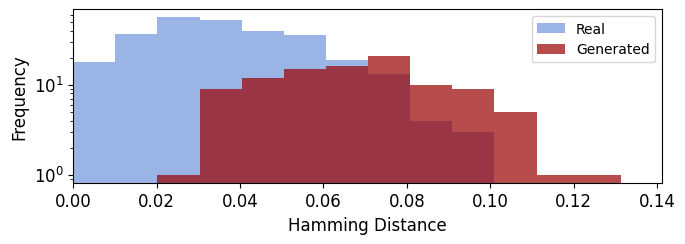

In [57]:
fig = evaluate.plot_hamming_novelty(minh_test, minh_gen)
fig.savefig(OUT_DIR+"plot_hamming_novelty_"+date+".pdf", dpi=200, bbox_inches='tight')

### PCA ordination of Jaccard similarity between real & generated genome vectors
Motivation: if real and generated genomes occupy different parts of the PCA plot, it suggests there is a serious fundamental difference in their composition. Alternatively, if their distributions overlap, it suggests a qualitative similarity.

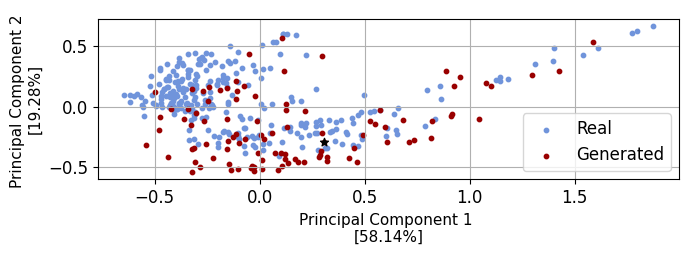

In [58]:
fig = evaluate.pca_gen_vs_real(generated, test_data, idx)
fig.savefig(OUT_DIR+"pca_gen_vs_real_jaccard_"+date+".pdf", dpi=200, bbox_inches='tight');

### Distributions of genes and modules per genome for real vs generated genomes

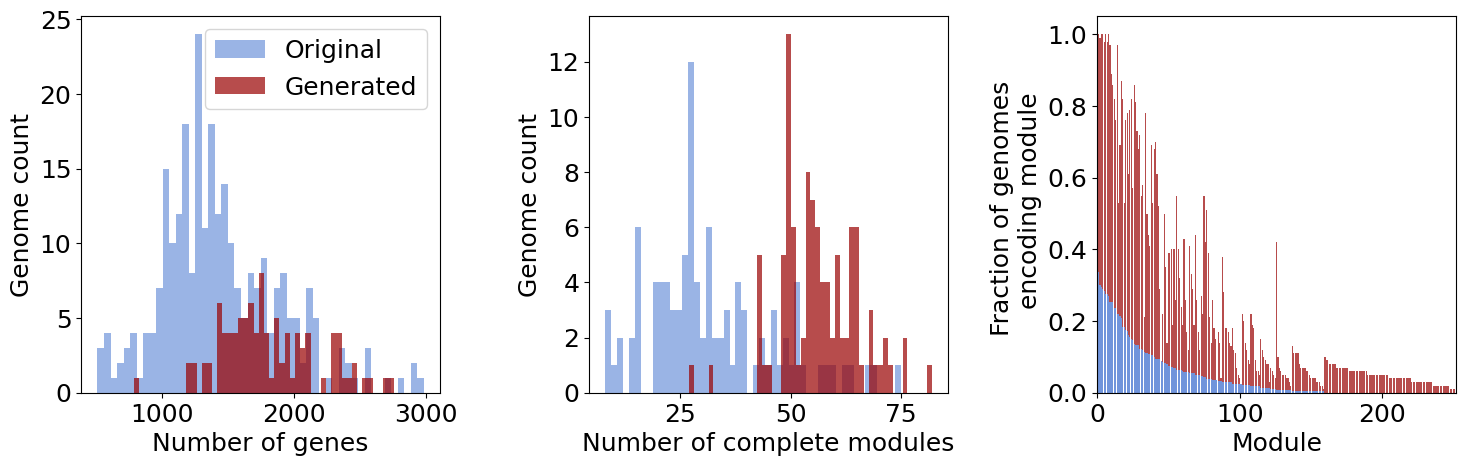

In [59]:
fig = evaluate.dist_genes_mods(generated, all_kos, mod_to_ko_clean, test_data)
fig.savefig(OUT_DIR+"dist_genes_mods_"+date+".pdf", dpi=200, bbox_inches='tight');

### Begin analysis of the randomly selected generated genome

Of genes selected for input to the VAE, how many are also present in the output?

In [60]:
generated_inputs_binary = evaluate.generated_inputs_to_binary(generated_inputs, all_kos)

/Users/natasha/Documents/Research/mcgill_postdoc/ncbi_genomes/genome_embeddings/evaluate.py:542: UserWarning: Attempting to set identical left == right == 100 results in singular transformations; automatically expanding.
  plt.xlim((min(perc_out)),100)


There are 100 instance of inputs being 100% present in output
This is out of 100 instances or 100.0% of cases
There are 100 instance of inputs being >=90% present in output (100.0%)


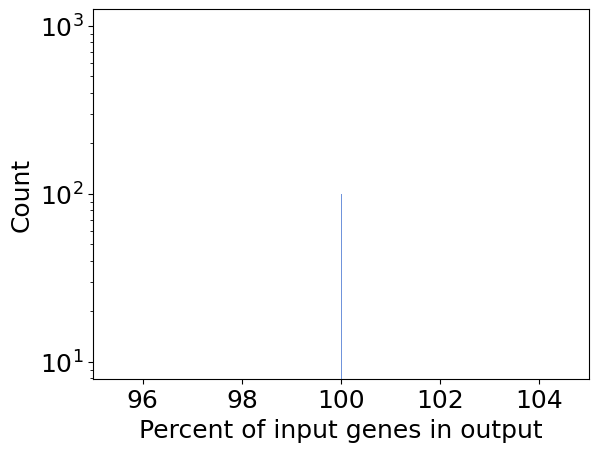

In [61]:
fig = evaluate.compare_in_n_out(generated, generated_inputs_binary)

Which modules were used as inputs to the generated genome vector?

In [62]:
generated_inputs[gen_idx][0]

['M00631',
 'M00649',
 'M00545',
 'M00150',
 'M00124',
 'M00554',
 'M00165',
 'M00833',
 'M00156',
 'M00140']

In the event that not all mods are complete, you can figure out which ones they are and how incomplete they are with the following code

In [63]:
# evaluate.id_incomplete_mods(generated_inputs, gen_idx, mod_to_ko_clean, gen_kos)

How many and which genes do/es this correspond to?

In [64]:
gen_kos = evaluate.kos_in_gen(generated, gen_idx, all_kos)

There are a total of 2015 genes encoded in this genome vector


Assess ribosomal completeness

In [65]:
pathways.confirm_ribosome(gen_kos)

missing RP S30
missing RP S31
missing RP L7A
ssu_count 21 / 23
lsu_count 33 / 34


Assess rRNA gene completeness (16S, 5s, 23s)

In [66]:
pathways.confirm_rrna(gen_kos)

present 3 / 3


In [67]:
len(gen_kos)

2015

The next steps of the metabolic analysis for our selected generated genome will be done using the KEGG Mapper “reconstruct” tool, available at https://www.genome.jp/kegg/mapper/reconstruct.html (Kanehisa & Sato, 2020; Kanehisa et al., 2022).

We will print the KOs from the generated genome vector in a format that will be accepted by this tool.

In [68]:
evaluate.export_selected_generated(OUT_DIR, gen_kos, gen_idx)

saving file to /Users/natasha/Desktop/DeepGenome/output/prot_out_13_2024-11-17-15-55-25.txt


### Parsimony-based dendrogram of real vs generated genomes

Motivation: above, we used hamming distance + Jaccard similarity to measure how similar real vs generated genome vectors are to one another. This considers gene overlap but not gene identity. For example, if all generated genomes were lacking ribosomes, rRNA genes, and other core machinery/pathways, they would be deeply abnormal, even if they were identical to the real genomes in all other ways. To gain insight into whether the composition of generated genome vectors is similar to that of real genome vectors, we will make a parsimony-based dendrogram generated from a character matrix where each gene’s presence/absence in a genome is a character.

The core of this analysis will be done through third party programs, but we will prepare the data for those programs here.

Will use phylip to infer a parsimony-based dendrogram (mix program)

Will use iTOL platform (https://itol.embl.de/) for visualization (display, add colour strips, taxon labels)

Prepare "phylip_in.txt" file for input to phylip.

In [69]:
# Get archaeal root for dendrogram
barc_vec = evaluate.arch_root(all_kos)
# Reformat tensor for input to phylip
df = evaluate.df_for_phylip(generated, test_data, test_genomes, all_kos)
df = df.append(pd.DataFrame({col: [val] for col, val in zip(df.columns, barc_vec)}, ['outgroup_T04065']))
phylum_dict = evaluate.write_out_for_phylip(OUT_DIR, df, tnum_to_tla, test_tax_dict) # phylip_in.txt

file will be saved as /Users/natasha/Desktop/DeepGenome/output/phylip_in2024-11-17-15-55-26.txt


Some tips for how to do the analysis in phylip:
    1. Navigate to "phylip-3.695-vol", double click "mix" program
    2. Enter file name with path to dir ---> delete space at the end of the file name

Phylip will produce a tree file that can be uploaded to iTOL. To add colour strips to the tree for real vs generated genomes, as seen in the figure in the paper, you will need the following files:

In [70]:
# For parsimony dendrogram: generate real genomes' phylum-level colour strip file for iTOL 
phyla_colours = evaluate.get_phyla_colours()
evaluate.colour_real_itol(OUT_DIR, phyla_colours, phylum_dict) # vae_dendro_colours_real.txt

file will be saved as /Users/natasha/Desktop/DeepGenome/output/vae_dendro_colours_real2024-11-17-15-55-27.txt


In [71]:
# For parsimony dendrogram: generate generated genomes' colour strip file for iTOL
evaluate.colour_generated_itol(OUT_DIR, phylum_dict) # vae_dendro_colours_generated.txt

file will be saved as /Users/natasha/Desktop/DeepGenome/output/vae_dendro_colours_generated2024-11-17-15-55-27.txt


# Baseline models

### Baseline 1
Generate genome vectors by completely randomly turn on n bits, where n = a randomly selected number of genes encoded by a real genome from the training set.

In [72]:
new = False

if new:
    date = pre_process.datenow()
    print("Generating new baseline 1")
    baseline1 = evaluate.baseline1(corrupted_train, tla_to_mod_to_kos, tnum_to_kos, tla_to_tnum, 
                                   c_train_genomes, corrupted_test)
    torch.save(baseline1, OUT_DIR+"baseline1"+date+".pt")
else:
    date_to_open = "2023-10-9-20-41-26"
    print("Loading previously made baseline 1")
    baseline1 = torch.load(OUT_DIR+"baseline1"+date_to_open+".pt")

Loading previously made baseline 1


In [73]:
f1 = sk.metrics.f1_score(uncorrupted_test, baseline1, zero_division=0, average='micro')
f1

0.1925303094538915

In [74]:
tns, fps, fns, tps = evaluate.confusion(uncorrupted_test, baseline1)

The percentage of TNs, FPs, FNs, and TPs, respectively, is: 68.49 (%) 16.77 (%) 11.39 (%) 3.36 (%)


In [75]:
evaluate.auroc(uncorrupted_test, baseline1)

0.5154976704168364

### Baseline 2
Generate genome vectors by randomly turn on n bits with the highest probability of being on across the entire training set. n = a randomly selected number of genes encoded by a real genome from the training set

In [76]:
new = False

if new:
    date = pre_process.datenow()
    print("Generating new baseline 2")
    baseline2 = evaluate.baseline2(train_data, tla_to_mod_to_kos, tnum_to_kos, \
                                   tla_to_tnum, c_train_genomes, corrupted_test)
    torch.save(baseline2, OUT_DIR+"baseline2"+date+".pt")
else:
    date_to_open = "2023-10-9-20-54-54"
    print("Loading previously made baseline 2")
    baseline2 = torch.load(OUT_DIR+"baseline2"+date_to_open+".pt")

Loading previously made baseline 2


In [77]:
f1 = sk.metrics.f1_score(uncorrupted_test.numpy(), baseline2, zero_division=0, average='micro')
f1

0.16219874756600267

In [78]:
tns, fps, fns, tps = evaluate.confusion(uncorrupted_test, baseline2)

The percentage of TNs, FPs, FNs, and TPs, respectively, is: 67.95 (%) 17.3 (%) 11.91 (%) 2.83 (%)


In [79]:
evaluate.auroc(uncorrupted_test, baseline2)

0.4944475255077354

### Baseline 3
Generate genome vectors using an untrained version of the VAE model.

In [80]:
new = False

if new:
    date = pre_process.datenow()
    print("Generating new baseline 3")
    n_features = int(corrupted_test.shape[1])
    fake_model = models.VariationalAutoEncoder(n_features, 3)
    fake_model.eval()
    with torch.no_grad():
        pred = fake_model.forward(corrupted_test[:,:n_features])[0].detach()
    baseline3 = evaluate.eval_binarize(pred, 0.5)
    torch.save(baseline3, OUT_DIR+"baseline3"+date+".pt")
else:
    date_to_open = "2023-10-9-21-13-1"
    print("Loading previously made baseline 3")
    baseline3 = torch.load(OUT_DIR+"baseline3"+date_to_open+".pt")

Loading previously made baseline 3


In [81]:
f1 = sk.metrics.f1_score(uncorrupted_test, baseline3, zero_division=0, average='micro')
f1

0.22866412431910957

In [82]:
tns, fps, fns, tps = evaluate.confusion(uncorrupted_test, baseline3)

The percentage of TNs, FPs, FNs, and TPs, respectively, is: 42.54 (%) 42.72 (%) 7.32 (%) 7.42 (%)


In [83]:
evaluate.auroc(uncorrupted_test, baseline3)

0.5010499593338346

### Baseline 4
All generated genome vectors are just copies of the smallest genome vector in the training set (_Hoaglandella endobia_ -- hed)

In [84]:
new = False

if new:
    date = pre_process.datenow()
    print("Generating new baseline 4")
    baseline4 = evaluate.baseline4(corrupted_train, corrupted_test, tla_to_tnum, tnum_to_kos, c_train_genomes)
    torch.save(baseline4, OUT_DIR+"baseline4"+date+".pt")
else:
    date_to_open = "2023-10-9-21-25-2"
    print("Loading previously made baseline 4")
    baseline4 = torch.load(OUT_DIR+"baseline4"+date_to_open+".pt")

Loading previously made baseline 4


In [85]:
f1 = sk.metrics.f1_score(uncorrupted_test, baseline4, zero_division=0, average='micro')
f1

0.3785836804704729

In [86]:
tns, fps, fns, tps = evaluate.confusion(uncorrupted_test, baseline4)

The percentage of TNs, FPs, FNs, and TPs, respectively, is: 83.89 (%) 1.37 (%) 10.98 (%) 3.76 (%)


In [87]:
evaluate.auroc(uncorrupted_test, baseline4)

0.6195562014137109

### Baseline 5
All generated genome vectors are just copies of the largest genome vector in the training set (_Paraburkholderia caribensis_ -- bcai)

In [88]:
new = False

if new:
    date = pre_process.datenow()
    print("Generating new baseline 5")
    baseline5, largest_tla = evaluate.baseline5(corrupted_train, corrupted_test, tla_to_tnum, 
                                                tnum_to_kos, c_train_genomes)
    torch.save(baseline5, OUT_DIR+"baseline5"+date+".pt")
else:
    date_to_open = "2023-10-9-21-36-27"
    print("Loading previously made baseline 5")
    baseline5 = torch.load(OUT_DIR+"baseline5"+date_to_open+".pt")

Loading previously made baseline 5


In [89]:
f1 = sk.metrics.f1_score(uncorrupted_test, baseline5, zero_division=0, average='micro')
f1

0.5166804496751665

In [90]:
tns, fps, fns, tps = evaluate.confusion(uncorrupted_test, baseline5)

The percentage of TNs, FPs, FNs, and TPs, respectively, is: 70.15 (%) 15.11 (%) 4.34 (%) 10.4 (%)


In [91]:
evaluate.auroc(uncorrupted_test, baseline5)

0.7640597606290566

# To generate new genome vectors

In [92]:
evaluate.new_vector_random(mod_to_ko_clean, model, all_kos)

K01069
K01159
K02357
K02654
K02665
K00283
K02238
K03075
K02358
K01933
K00945
K01692
K01724
K00507
K02967
K01012
K00031
K02887
K03629
K00941
K03560
K02338
K02065
K05540
K01782
K04088
K02653
K06949
K06891
K07040
K06980
K07646
K01950
K01969
K00121
K00640
K06941
K09014
K02863
K01866
K00020
K14998
K19123
K00239
K07003
K01768
K07071
K00791
K02427
K07391
K03558
K00970
K14221
K03496
K02650
K03469
K00855
K11753
K11410
K00766
K07497
K03547
K00647
K24119
K06923
K11741
K02881
K00108
K03598
K02340
K02952
K01142
K01214
K16264
K00140
K07030
K02838
K03590
K03702
K00697
K03699
K07068
K01814
K00645
K02010
K00340
K00817
K00783
K03154
K03741
K00872
K19302
K14170
K01256
K07124
K01588
K04075
K00852
K03216
K03581
K01255
K06902
K02527
K00036
K03643
K05786
K05516
K07447
K13018
K14393
K06041
K06997
K00765
K01992
K03724
K03574
K01978
K03630
K02112
K00287
K00761
K02029
K01061
K04755
K00425
K02965
K06177
K01496
K06176
K00655
K00790
K14236
K02956
K14234
K06131
K01736
K01591
K09951
K03043
K03637
K02982
K00566
K02047